In [ ]:
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

seq_file_name = '625_38n18_1_2mm_-161_07_41_19_806'

# --- ŚCIEŻKI ---
NEW_IMAGE_DIR = f'../frames_output/{seq_file_name}/preview_fixed'  # zmień na swój katalog
MODEL_ARC_PATH = '../models/autoencoder_arc_reference.pth'
MODEL_WELD_PATH = '../models/autoencoder_weld_reference.pth'
# /home/dburcon/studia/SeqDataReadingProject/models
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_SIZE = (64, 64)

# --- TRANSFORMACJE ---
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

# --- STRUKTURA MODELU ---
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# --- ŁADOWANIE MODELÓW ---
model_arc = ConvAutoencoder().to(DEVICE)
model_arc.load_state_dict(torch.load(MODEL_ARC_PATH))
model_arc.eval()

model_weld = ConvAutoencoder().to(DEVICE)
model_weld.load_state_dict(torch.load(MODEL_WELD_PATH))
model_weld.eval()

# --- DATASET Z ROIs ---
class ThermalDatasetMultiROI(Dataset):
    def __init__(self, image_dir, transform=None):
        self.files = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
        self.transform = transform
        self.roi_arc = (295, 410, 345, 480)
        self.roi_weld = (270, 250, 370, 400)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        arc_crop = img.crop(self.roi_arc)
        weld_crop = img.crop(self.roi_weld)
        if self.transform:
            arc_crop = self.transform(arc_crop)
            weld_crop = self.transform(weld_crop)
        return arc_crop, weld_crop, os.path.basename(self.files[idx])

# --- DANE I PRZETWARZANIE ---
dataset = ThermalDatasetMultiROI(NEW_IMAGE_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
criterion = nn.MSELoss()

errors_arc, errors_weld, filenames = [], [], []

with torch.no_grad():
    for arc, weld, fname in dataloader:
        arc = arc.to(DEVICE)
        weld = weld.to(DEVICE)

        recon_arc = model_arc(arc)
        recon_weld = model_weld(weld)

        err_arc = criterion(recon_arc, arc).item()
        err_weld = criterion(recon_weld, weld).item()

        errors_arc.append(err_arc)
        errors_weld.append(err_weld)
        filenames.append(fname[0])

# --- PROGI I WYKRYWANIE ---
threshold_arc = np.percentile(errors_arc, 95)
threshold_weld = np.percentile(errors_weld, 95)

anomalies_arc = [i for i, e in enumerate(errors_arc) if e > threshold_arc]
anomalies_weld = [i for i, e in enumerate(errors_weld) if e > threshold_weld]

# --- WIZUALIZACJA ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(errors_arc, label="Arc Error")
plt.axhline(threshold_arc, color='r', linestyle='--', label='Threshold')
plt.scatter(anomalies_arc, [errors_arc[i] for i in anomalies_arc], color='orange', label='Anomalies')
plt.title("Anomalie łuku")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(errors_weld, label="Weld Error")
plt.axhline(threshold_weld, color='r', linestyle='--', label='Threshold')
plt.scatter(anomalies_weld, [errors_weld[i] for i in anomalies_weld], color='orange', label='Anomalies')
plt.title("Anomalie spoiny")
plt.legend()

plt.tight_layout()
plt.show()

/home/dburcon/.pyenv/versions/3.10.15/envs/thermal_3.10/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Zapisano plik z SSIM: ../frames_output/625_38n18_1_2mm_-161_07_41_19_806/ssim_errors.csv


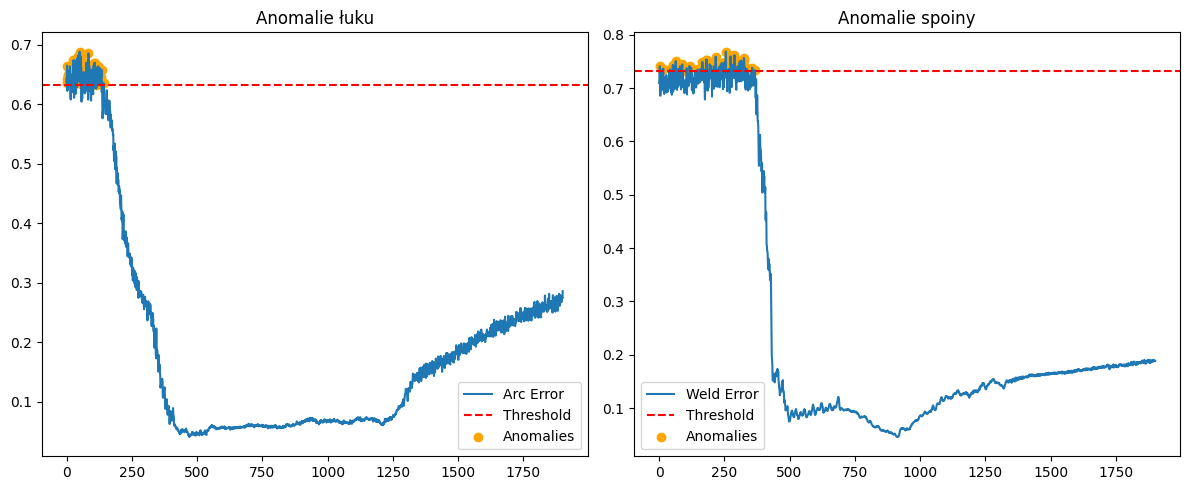

In [1]:
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import structural_similarity_index_measure as ssim

# === KONFIGURACJA ===
seq_file_name = '625_38n18_1_2mm_-161_07_41_19_806'  # ← ← ← TUTAJ wpisz nazwę sekwencji!
IMAGE_DIR = f'../frames_output/{seq_file_name}/preview_fixed'
IMAGE_SIZE = (64, 64)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# === TRANSFORMACJE ===
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

# === DATASET ===
class ThermalDatasetMultiROI(Dataset):
    def __init__(self, image_dir, transform=None):
        self.files = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
        self.transform = transform
        self.roi_arc = (295, 410, 345, 480)   # ROI łuku
        self.roi_weld = (270, 250, 370, 400)  # ROI spoiny

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        arc_crop = img.crop(self.roi_arc)
        weld_crop = img.crop(self.roi_weld)
        if self.transform:
            arc_crop = self.transform(arc_crop)
            weld_crop = self.transform(weld_crop)
        return arc_crop, weld_crop, os.path.basename(self.files[idx])

# === MODEL ===
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# === ZAŁADOWANIE MODELU ===
model_arc = ConvAutoencoder().to(DEVICE)
model_weld = ConvAutoencoder().to(DEVICE)
model_arc.load_state_dict(torch.load('../models/ssim/autoencoder_arc_reference.pth', map_location=DEVICE))
model_weld.load_state_dict(torch.load('../models/ssim/autoencoder_weld_reference.pth', map_location=DEVICE))
model_arc.eval()
model_weld.eval()

# === PRZYGOTOWANIE DANYCH ===
dataset = ThermalDatasetMultiROI(IMAGE_DIR, transform=transform)
filenames = []
errors_arc, errors_weld = [], []

anomalia_path = f'./anomalie_output/{seq_file_name}'
os.makedirs(anomalia_path, exist_ok=True)


# === DETEKCJA ANOMALII ===
with torch.no_grad():
    for arc, weld, fname in DataLoader(dataset, batch_size=1, shuffle=False):
        arc = arc.to(DEVICE)
        weld = weld.to(DEVICE)

        recon_arc = model_arc(arc)
        recon_weld = model_weld(weld)

        err_arc = (1.0 - ssim(recon_arc, arc)).cpu().item()
        err_weld = (1.0 - ssim(recon_weld, weld)).cpu().item()

        errors_arc.append(err_arc)
        errors_weld.append(err_weld)
        filenames.append(fname[0])


# === ZAPIS błędów SSIM do CSV ===
df_ssim = pd.DataFrame({
    "Frame": filenames,
    "ArcSSIM": errors_arc,
    "WeldSSIM": errors_weld
})

ssim_csv_path = f"../frames_output/{seq_file_name}/ssim_errors.csv"
df_ssim.to_csv(ssim_csv_path, index=False)
print(f"Zapisano plik z SSIM: {ssim_csv_path}")

# === PRÓG i WYKRYTE ANOMALIE ===
thresh_arc = np.percentile(errors_arc, 95)
thresh_weld = np.percentile(errors_weld, 95)
anomalies_arc = [i for i, e in enumerate(errors_arc) if e > thresh_arc]
anomalies_weld = [i for i, e in enumerate(errors_weld) if e > thresh_weld]

# === ZAPIS ANOMALII + HEATMAPY ===
for i in anomalies_arc:
    fname = filenames[i]
    arc, _, _ = dataset[i]
    recon = model_arc(arc.unsqueeze(0).to(DEVICE)).cpu().squeeze(0)
    diff = torch.abs(recon - arc).squeeze().detach().numpy()

    plt.imshow(diff, cmap='hot')
    plt.title(f"Arc anomaly: {fname}")
    plt.colorbar()
    plt.savefig(os.path.join(anomalia_path, f"heatmap_arc_{fname}.png"))
    plt.close()

    img = Image.open(os.path.join(IMAGE_DIR, fname))
    img.save(os.path.join(anomalia_path, f"anomaly_arc_{fname}"))

for i in anomalies_weld:
    fname = filenames[i]
    _, weld, _ = dataset[i]
    recon = model_weld(weld.unsqueeze(0).to(DEVICE)).cpu().squeeze(0)
    diff = torch.abs(recon - weld).squeeze().detach().numpy()

    plt.imshow(diff, cmap='hot')
    plt.title(f"Weld anomaly: {fname}")
    plt.colorbar()
    plt.savefig(os.path.join(anomalia_path, f"heatmap_weld_{fname}.png"))
    plt.close()

    img = Image.open(os.path.join(IMAGE_DIR, fname))
    img.save(os.path.join(anomalia_path, f"anomaly_weld_{fname}"))

# === WYKRES BŁĘDÓW ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(errors_arc, label='Arc Error')
plt.axhline(y=thresh_arc, color='red', linestyle='--', label='Threshold')
plt.scatter(anomalies_arc, [errors_arc[i] for i in anomalies_arc], color='orange', label='Anomalies')
plt.title('Anomalie łuku')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(errors_weld, label='Weld Error')
plt.axhline(y=thresh_weld, color='red', linestyle='--', label='Threshold')
plt.scatter(anomalies_weld, [errors_weld[i] for i in anomalies_weld], color='orange', label='Anomalies')
plt.title('Anomalie spoiny')
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# === ŚCIEŻKI ===
seq_file_name = '625_38n18_1_2mm_-161_07_41_19_806'
csv_temp = f'../frames_output/{seq_file_name}/temperature_stats.csv'
csv_ssim = f'../frames_output/{seq_file_name}/ssim_errors.csv'

# === WCZYTANIE ===
df_temp = pd.read_csv(csv_temp)
df_ssim = pd.read_csv(csv_ssim)

# === NORMALIZACJA NAZW (bez rozszerzeń) ===
df_temp["FrameBase"] = df_temp["Frame"].apply(lambda x: os.path.splitext(x)[0])
df_ssim["FrameBase"] = df_ssim["Frame"].apply(lambda x: os.path.splitext(x)[0])

# === MERGE po FrameBase ===
df_merged = pd.merge(df_temp, df_ssim, on="FrameBase", how="inner")

# === ZAPIS ===
df_merged.to_csv(f'../frames_output/{seq_file_name}/combined_data.csv', index=False)
print("Połączone dane zapisane do combined_data.csv")

Połączone dane zapisane do combined_data.csv


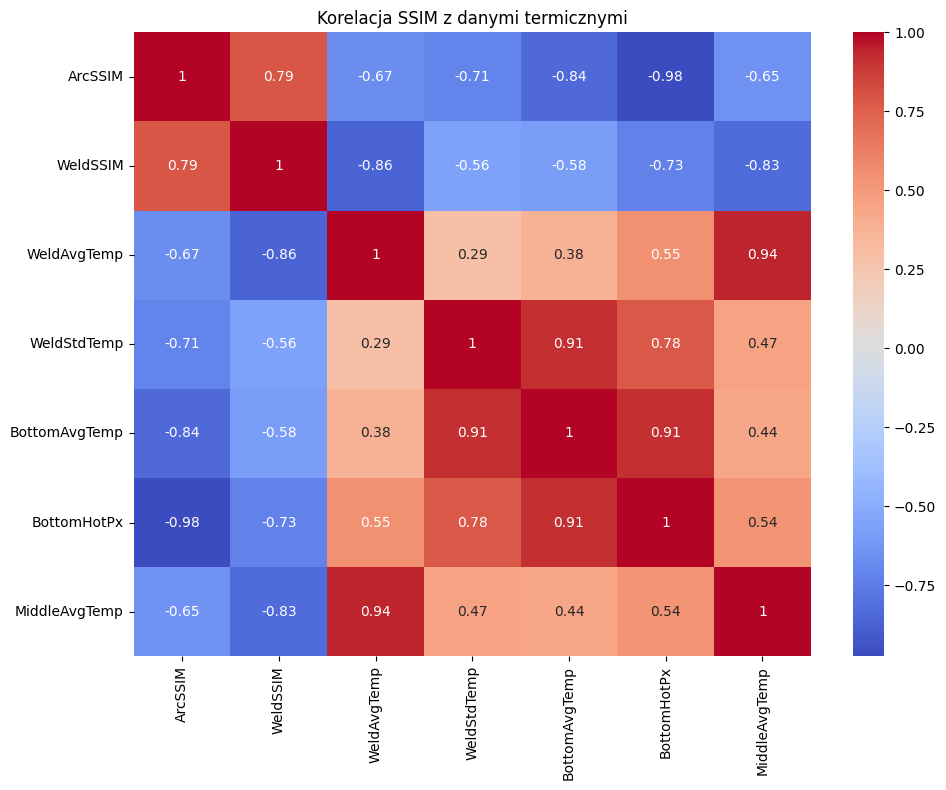

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === WCZYTANIE ===
seq_file_name = '625_38n18_1_2mm_-161_07_41_19_806'
df = pd.read_csv(f'../frames_output/{seq_file_name}/combined_data.csv')

# === WIZUALIZACJA KORELACJI ===
corr = df[[
    'ArcSSIM', 'WeldSSIM',
    'WeldAvgTemp', 'WeldStdTemp',
    'BottomAvgTemp', 'BottomHotPx', 'MiddleAvgTemp'
]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Korelacja SSIM z danymi termicznymi")
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd

# === WCZYTANIE ===
seq_file_name = '625_38n18_1_2mm_-161_07_41_19_806'
df = pd.read_csv(f'../frames_output/{seq_file_name}/combined_data.csv')

# === PROSTA REGUŁA ANOMALII ===
df['Anomaly'] = (
    (df['ArcSSIM'] < 0.65) |  # czyli tylko naprawdę niskie SSIM
    (df['WeldAvgTemp'] < 330) |
    (df['WeldStdTemp'] > 70) |
    (df['BottomHotPx'] > 10)
).astype(int)

df.to_csv(f'../frames_output/{seq_file_name}/labeled_data.csv', index=False)
print("Etykiety anomalii zapisane w labeled_data.csv")


Etykiety anomalii zapisane w labeled_data.csv


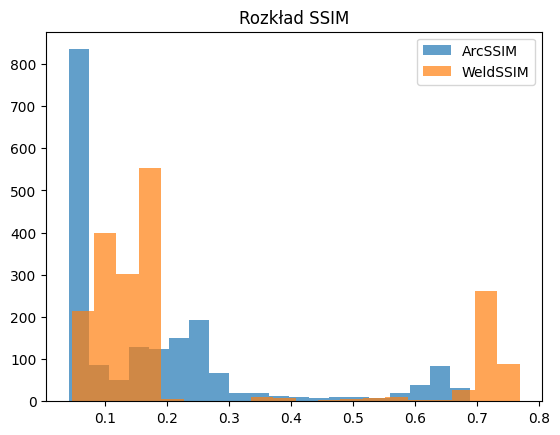

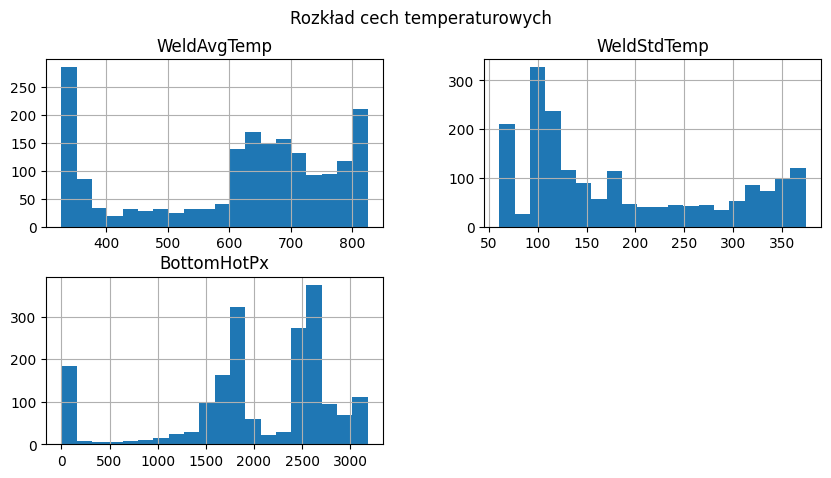

In [13]:
import matplotlib.pyplot as plt
df = pd.read_csv(f'../frames_output/{seq_file_name}/combined_data.csv')

plt.hist(df["ArcSSIM"], bins=20, alpha=0.7, label='ArcSSIM')
plt.hist(df["WeldSSIM"], bins=20, alpha=0.7, label='WeldSSIM')
plt.legend()
plt.title("Rozkład SSIM")
plt.show()

df[["WeldAvgTemp", "WeldStdTemp", "BottomHotPx"]].hist(bins=20, figsize=(10, 5))
plt.suptitle("Rozkład cech temperaturowych")
plt.show()
